# **Homework 0: Introduction to Isaac Environment**


**Member**
- Pavaris Asawakijtananont 65340500037
- Natnasa Lertmahakul 65340500021

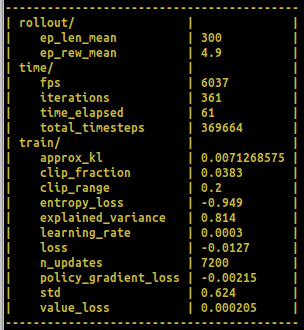

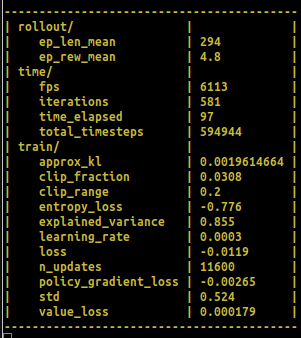

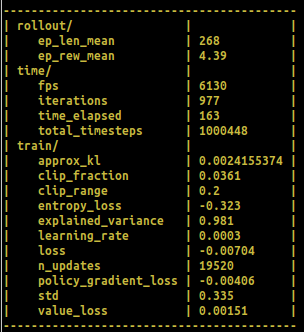

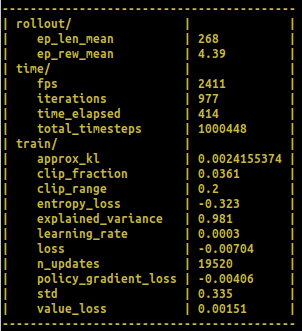

## **Part 1: Take a Look at Cartpole Rl Agent**

### **Questions**
*Submit the answers to the following questions*:
1.  According to the tutorials, if we want to edit the environment configuration, action space, observation space, reward function, or termination condition of the Isaac-Cartpole-v0 task, which file should we look at, and where is each part located?
2.  What are the action space and observation space for an agent defined in the Isaac-Cartpole-v0 task?
3.  How can episodes in the Isaac-Cartpole-v0 task be terminated?
4.  How many reward terms are used to train an agent in the Isaac-Cartpole-v0 task?


#### **Answer 1.1**
*1. According to the tutorials, if we want to edit the environment configuration, action space, observation space, reward function, or termination condition of the Isaac-Cartpole-v0 task, which file should we look at, and where is each part located?*

From running program according to the tutorials 


`python source/standalone/workflows/sb3/train.py --task Isaac-Cartpole-v0 --num_envs 64 --headless --video --video_length 500 --video_interval 1000`



We can known source program file for execute in IsaacLab folder, the execute program is name `train.py`, with in main function `main(env_cfg: ManagerBasedRLEnvCfg | DirectRLEnvCfg | DirectMARLEnvCfg, agent_cfg: dict)` that require a 2 parameter with environment configure and agent configure and got pass by  
```
@hydra_task_config(args_cli.task, "sb3_cfg_entry_point")
```
in line 72 of program in. By `args_cli.task` is got update environment and agent file while running program in CLI 

Dive into **`hydra_task_config`**

We can found function in path *`source/extensions/omni.isaac.lab_tasks/omni/isaac/lab_tasks/utils/hydra.py`*

```python
def hydra_task_config(task_name: str, agent_cfg_entry_point: str) -> Callable:
    """Decorator to handle the Hydra configuration for a task.

    This decorator registers the task to Hydra and updates the environment and agent configurations from Hydra parsed
    command line arguments.

    Args:
        task_name: The name of the task.
        agent_cfg_entry_point: The entry point key to resolve the agent's configuration file.

    Returns:
        The decorated function with the envrionment's and agent's configurations updated from command line arguments.
    """

    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            # register the task to Hydra
            env_cfg, agent_cfg = register_task_to_hydra(task_name, agent_cfg_entry_point)

            # define the new Hydra main function
            @hydra.main(config_path=None, config_name=task_name, version_base="1.3")
            def hydra_main(hydra_env_cfg: DictConfig, env_cfg=env_cfg, agent_cfg=agent_cfg):
                # convert to a native dictionary
                hydra_env_cfg = OmegaConf.to_container(hydra_env_cfg, resolve=True)
                # replace string with slices because OmegaConf does not support slices
                hydra_env_cfg = replace_strings_with_slices(hydra_env_cfg)
                # update the configs with the Hydra command line arguments
                env_cfg.from_dict(hydra_env_cfg["env"])
                # replace strings that represent gymnasium spaces because OmegaConf does not support them.
                # this must be done after converting the env configs from dictionary to avoid internal reinterpretations
                replace_strings_with_env_cfg_spaces(env_cfg)
                # get agent configs
                if isinstance(agent_cfg, dict):
                    agent_cfg = hydra_env_cfg["agent"]
                else:
                    agent_cfg.from_dict(hydra_env_cfg["agent"])
                # call the original function
                func(env_cfg, agent_cfg, *args, **kwargs)

            # call the new Hydra main function
            hydra_main()

        return wrapper

    return decorator
```


from the CLI we pass argument *--task `Isaac-Cartpole-v0`* and *`"sb3_cfg_entry_point"` in code* to `hydra_task_config` function to return the decorated function with the envrionment's and agent's configurations updated from command line arguments.
+ and it's have call `register_task_to_hydra` to return a tuple containing the parsed environment and agent configuration objects.
    + and call `load_cfg_from_registry` to return the parsed configuration object
*Source*
- `hydra_task_config` and  `register_task_to_hydra` function
    - https://github.com/isaac-sim/IsaacLab/blob/b5078debe1896c449d5b3a940cebe21bf1560bd0/source/extensions/omni.isaac.lab_tasks/omni/isaac/lab_tasks/utils/hydra.py#L61 []
- `load_cfg_from_registry` function 
    - https://github.com/isaac-sim/IsaacLab/blob/main/source/extensions/omni.isaac.lab_tasks/omni/isaac/lab_tasks/utils/parse_cfg.py#L19

or in CLI *task* arguments we can locate path of *task* in **IsaacLab** folder is in `source/extensions/omni.isaac.lab_tasks/omni/isaac/lab_tasks/manager_based/classic/cartpole` is contain with configure file is **`cartpole_env_cfg.py`** and task is calling in **`__init__.py`** with register with task name(id) in CLI

```python
# code from __init__.py
gym.register(
    id="Isaac-Cartpole-v0",
    entry_point="omni.isaac.lab.envs:ManagerBasedRLEnv",
    disable_env_checker=True,
    kwargs={
        "env_cfg_entry_point": f"{__name__}.cartpole_env_cfg:CartpoleEnvCfg", # Call enviroment is this line
        "rl_games_cfg_entry_point": f"{agents.__name__}:rl_games_ppo_cfg.yaml",
        "rsl_rl_cfg_entry_point": f"{agents.__name__}.rsl_rl_ppo_cfg:CartpolePPORunnerCfg",
        "skrl_cfg_entry_point": f"{agents.__name__}:skrl_ppo_cfg.yaml",
        "sb3_cfg_entry_point": f"{agents.__name__}:sb3_ppo_cfg.yaml", # Call agent this line
    },
)
```


In better we can found configuration path of environment in https://isaac-sim.github.io/IsaacLab/main/source/overview/environments.html
https://github.com/isaac-sim/IsaacLab/blob/main/source/extensions/omni.isaac.lab_tasks/omni/isaac/lab_tasks/manager_based/classic/cartpole/cartpole_env_cfg.py


Configuration file is in `/source/extensions/omni.isaac.lab_tasks/omni/isaac/lab_tasks/manager_based/classic/cartpole/cartpole_env_cfg.py` 
- **Environment Configuration** : in line 158 in `class CartpoleEnvCfg(ManagerBasedRLEnvCfg)` it's contain all configuration includes scene , observations , events , rewards , terminations.
    ```python
    @configclass
    class CartpoleEnvCfg(ManagerBasedRLEnvCfg):
        """Configuration for the cartpole environment."""

        # Scene settings
        scene: CartpoleSceneCfg = CartpoleSceneCfg(num_envs=4096, env_spacing=4.0)
        # Basic settings
        observations: ObservationsCfg = ObservationsCfg()
        actions: ActionsCfg = ActionsCfg()
        events: EventCfg = EventCfg()
        # MDP settings
        rewards: RewardsCfg = RewardsCfg()
        terminations: TerminationsCfg = TerminationsCfg()

        # Post initialization
        def __post_init__(self) -> None:
            """Post initialization."""
            # general settings
            self.decimation = 2
            self.episode_length_s = 5
            # viewer settings
            self.viewer.eye = (8.0, 0.0, 5.0)
            # simulation settings
            self.sim.dt = 1 / 120
            self.sim.render_interval = self.decimation
```

- **Action Space** : in line 59 in `class ActionsCfg`

    ```python
    class ActionsCfg:
        """Action specifications for the MDP."""

        joint_effort = mdp.JointEffortActionCfg(asset_name="robot", joint_names=["slider_to_cart"], scale=100.0)
    ```
    - setting joint effort to target


- **Observation Space** : in line 65 in `class ObservationsCfg`

    ```python

    @configclass
    class ObservationsCfg:
        """Observation specifications for the MDP."""

        @configclass
        class PolicyCfg(ObsGroup):
            """Observations for policy group."""

            # observation terms (order preserved)
            joint_pos_rel = ObsTerm(func=mdp.joint_pos_rel)
            joint_vel_rel = ObsTerm(func=mdp.joint_vel_rel)

            def __post_init__(self) -> None:
                self.enable_corruption = False
                self.concatenate_terms = True

        # observation groups
        policy: PolicyCfg = PolicyCfg()

    ```

    - policy group can observe joint position and joint velocity

- **Reward function**  : in line  112 in `class RewardsCfg`

    ```python
    class RewardsCfg:
    """Reward terms for the MDP."""

    # (1) Constant running reward
    alive = RewTerm(func=mdp.is_alive, weight=1.0)
    # (2) Failure penalty
    terminating = RewTerm(func=mdp.is_terminated, weight=-2.0)
    # (3) Primary task: keep pole upright
    pole_pos = RewTerm(
        func=mdp.joint_pos_target_l2,
        weight=-1.0,
        params={"asset_cfg": SceneEntityCfg("robot", joint_names=["cart_to_pole"]), "target": 0.0},
    )
    # (4) Shaping tasks: lower cart velocity
    cart_vel = RewTerm(
        func=mdp.joint_vel_l1,
        weight=-0.01,
        params={"asset_cfg": SceneEntityCfg("robot", joint_names=["slider_to_cart"])},
    )
    # (5) Shaping tasks: lower pole angular velocity
    pole_vel = RewTerm(
        func=mdp.joint_vel_l1,
        weight=-0.005,
        params={"asset_cfg": SceneEntityCfg("robot", joint_names=["cart_to_pole"])},
    )
    ```

- **Termination Condition** in line 140 `class TerminationCfg`

    ```python
    class TerminationsCfg:
    """Termination terms for the MDP."""

    # (1) Time out
    time_out = DoneTerm(func=mdp.time_out, time_out=True)
    # (2) Cart out of bounds
    cart_out_of_bounds = DoneTerm(
        func=mdp.joint_pos_out_of_manual_limit,
        params={"asset_cfg": SceneEntityCfg("robot", joint_names=["slider_to_cart"]), "bounds": (-3.0, 3.0)},
    )
    ```    

- **Environment configuration** in line 158 `class CartpoleEnvCfg(ManagerBasedRLEnvCfg)`
    ```python
    class CartpoleEnvCfg(ManagerBasedRLEnvCfg):
    """Configuration for the cartpole environment."""

    # Scene settings
    scene: CartpoleSceneCfg = CartpoleSceneCfg(num_envs=4096, env_spacing=4.0)
    # Basic settings
    observations: ObservationsCfg = ObservationsCfg()
    actions: ActionsCfg = ActionsCfg()
    events: EventCfg = EventCfg()
    # MDP settings
    rewards: RewardsCfg = RewardsCfg()
    terminations: TerminationsCfg = TerminationsCfg()

    # Post initialization
    def __post_init__(self) -> None:
        """Post initialization."""
        # general settings
        self.decimation = 2
        self.episode_length_s = 5
        # viewer settings
        self.viewer.eye = (8.0, 0.0, 5.0)
        # simulation settings
        self.sim.dt = 1 / 120
        self.sim.render_interval = self.decimation
    ```
    - this class setting all environment configure
        - defalut value of number of environments if not input value in command line(default 4096)


---

#### **Answer 1.2**
*2.  What are the action space and observation space for an agent defined in the Isaac-Cartpole-v0 task?*


In file `source/extensions/omni.isaac.lab_tasks/omni/isaac/lab_tasks/manager_based/classic/cartpole/__init__.py` and in line 18

```python
gym.register(
    id="Isaac-Cartpole-v0",
    entry_point="omni.isaac.lab.envs:ManagerBasedRLEnv",
    disable_env_checker=True,
    kwargs={
        "env_cfg_entry_point": f"{__name__}.cartpole_env_cfg:CartpoleEnvCfg",
        "rl_games_cfg_entry_point": f"{agents.__name__}:rl_games_ppo_cfg.yaml",
        "rsl_rl_cfg_entry_point": f"{agents.__name__}.rsl_rl_ppo_cfg:CartpolePPORunnerCfg",
        "skrl_cfg_entry_point": f"{agents.__name__}:skrl_ppo_cfg.yaml",
        "sb3_cfg_entry_point": f"{agents.__name__}:sb3_ppo_cfg.yaml",
    },
)
```

are define environment configure of task in `cartpole_env_cfg` and agent configuration in `sb3_ppo_cfg.yaml`
- **Action Space** : in line 59
    ```python
    class ActionsCfg:
    """Action specifications for the MDP."""

    joint_effort = mdp.JointEffortActionCfg(asset_name="robot", joint_names=["slider_to_cart"], scale=100.0)
    ```
    - create an action term that controls the force applied to the cart(joint effort). to the cart to balance the pole

- **Observation Space** : in line 66

    ```python
    class ObservationsCfg:
    """Observation specifications for the MDP."""

    @configclass
    class PolicyCfg(ObsGroup):
        """Observations for policy group."""

        # observation terms (order preserved)
        joint_pos_rel = ObsTerm(func=mdp.joint_pos_rel)
        joint_vel_rel = ObsTerm(func=mdp.joint_vel_rel)

        def __post_init__(self) -> None:
            self.enable_corruption = False
            self.concatenate_terms = True

    # observation groups
    policy: PolicyCfg = PolicyCfg()
    ```
    - oservation group named **policy** to collect observation term including with 2 term(Joint Position and Joint Velocity term)


---

#### **Answer 1.3**
*3.How can episodes in the Isaac-Cartpole-v0 task be terminated?*

in `cartpole_env_cfg.py` in line 140

```python
class TerminationsCfg:
    """Termination terms for the MDP."""

    # (1) Time out
    time_out = DoneTerm(func=mdp.time_out, time_out=True) # this line
    # (2) Cart out of bounds
    cart_out_of_bounds = DoneTerm( # this line
        func=mdp.joint_pos_out_of_manual_limit,
        params={"asset_cfg": SceneEntityCfg("robot", joint_names=["slider_to_cart"]), "bounds": (-3.0, 3.0)},
    )
```

- termination conditions are have 2 conditions contain with

1. Time out : Terminate the episode when the episode length exceeds the maximum episode length (for current configure is 5 seconds)
2. Cart out of bounds : Terminate when the asset's joint positions are outside of the configured bounds.
    - in this line we setting boundary is -3 to 3


---

#### **Answer 1.4**
*4.How many reward terms are used to train an agent in the Isaac-Cartpole-v0 task?*

in line 112 `class RewardsCfg`
```python
class RewardsCfg:
    """Reward terms for the MDP."""

    # (1) Constant running reward
    alive = RewTerm(func=mdp.is_alive, weight=1.0)
    # (2) Failure penalty
    terminating = RewTerm(func=mdp.is_terminated, weight=-2.0)
    # (3) Primary task: keep pole upright
    pole_pos = RewTerm(
        func=mdp.joint_pos_target_l2,
        weight=-1.0,
        params={"asset_cfg": SceneEntityCfg("robot", joint_names=["cart_to_pole"]), "target": 0.0},
    )
    # (4) Shaping tasks: lower cart velocity
    cart_vel = RewTerm(
        func=mdp.joint_vel_l1,
        weight=-0.01,
        params={"asset_cfg": SceneEntityCfg("robot", joint_names=["slider_to_cart"])},
    )
    # (5) Shaping tasks: lower pole angular velocity
    pole_vel = RewTerm(
        func=mdp.joint_vel_l1,
        weight=-0.005,
        params={"asset_cfg": SceneEntityCfg("robot", joint_names=["cart_to_pole"])},
    )
```

- Including with **5 terms** of reward terms
1. **Constant running reward** : getting reward for being alive (weight : 1)

2. **Failure penalty** : Penalize terminated episodes that don't correspond to episodic timeouts. (weight : -2)

3. **Primary task: keep pole upright** : Penalize joint position deviation from a target value(target value is 0.0). (weight : -1.0) 

4. **Shaping tasks: lower cart velocity** : Penalize cart velocities. (weight : -0.01)

5. **Shaping tasks: lower pole angular velocity** : Penalize pole angular velocities. (weight : -0.005)


---

## **Part 2: Playing with Cartpole Rl Agent**

### **Questions**
Let us adjust the weight of each reward term specified in the Isaac-Cartpole-v0 task and train the agent. Which results will be affected by this adjustment, and why? Submit the answers.

You may further explore by modifying other aspects, such as the agent's action space, observation space, and termination conditions.

### **Answer**
#### **Experiment test**
- Experiment test for adjust different variable reward term weight 
1. **Primary task: keep pole upright** *default : -1*
    1.  `ken_1` - `to -3` : not difference from default a lot.
    2.  `ken_2` - `to -10` : reward term can saturation at same value with default, at the end cartpole is shaking a lot3.
    3.  `ken_3` - `to -50` : reward term can saturation at same value with default but slowly increasing and same with episode length, at the end cartpole is shaking a lot .
    4.  `ken_4` - `to 0.5` : highly reward but , **can't do a task**.
2. **Shaping tasks: lower cart velocity** *defalut : -0.01*
    1.  `ken_5` - `to -0.1` : not difference from default a lot.
    2.  `ken_6` - `to -0.5` : mean reward is very low at early period and very low  value compare with other experiment but cartpole is steady than other(less moving cart).
    3.  `cartvel1` - `to -0.5` : not difference from default a lot. but when reset position and velocity pole can stabilize faster.
3. **Shaping tasks: lower pole angular velocity** *default : -0.005*
    1.  `ken_7` - `to -0.1` : pole get in steady state slower(underdamp behavior).
    2.  `ken_8` - `to  0.0` : not difference from -0.1 a lot.
    3.  `ken_9` - `to 0.1` : not difference from -0.1 a lot.
        - because of angular velocity pole can control from cart velocity.
4. **Adjust Action** *default joint effort*
    - change action class to difference function 
    ```python
    class ActionsCfg:
    """Action specifications for the MDP."""
    joint_effort = mdp.JointEffortActionCfg(asset_name="robot", joint_names=["slider_to_cart"], scale=100.0)
    ```
    1. `teng_1` - `JointVelocityActionCfg` :  Cartpole can stabilize but cart has got high velocity to stabilize.
    2. `teng_2` - `PositionVelocityActionCfg` :  Cart can't stabilize and cart slowly move.
5. **Adjust Initial State** *default : 0*
    - adjust to start at pi/2 or lowest position.
    - cartpole must learn to swing up pole to stabilize too.
    - cartpole can stabilize pole but cart have highly speed to swing up the pole.
    - see video in `hokpip_1`


#### **Graph**

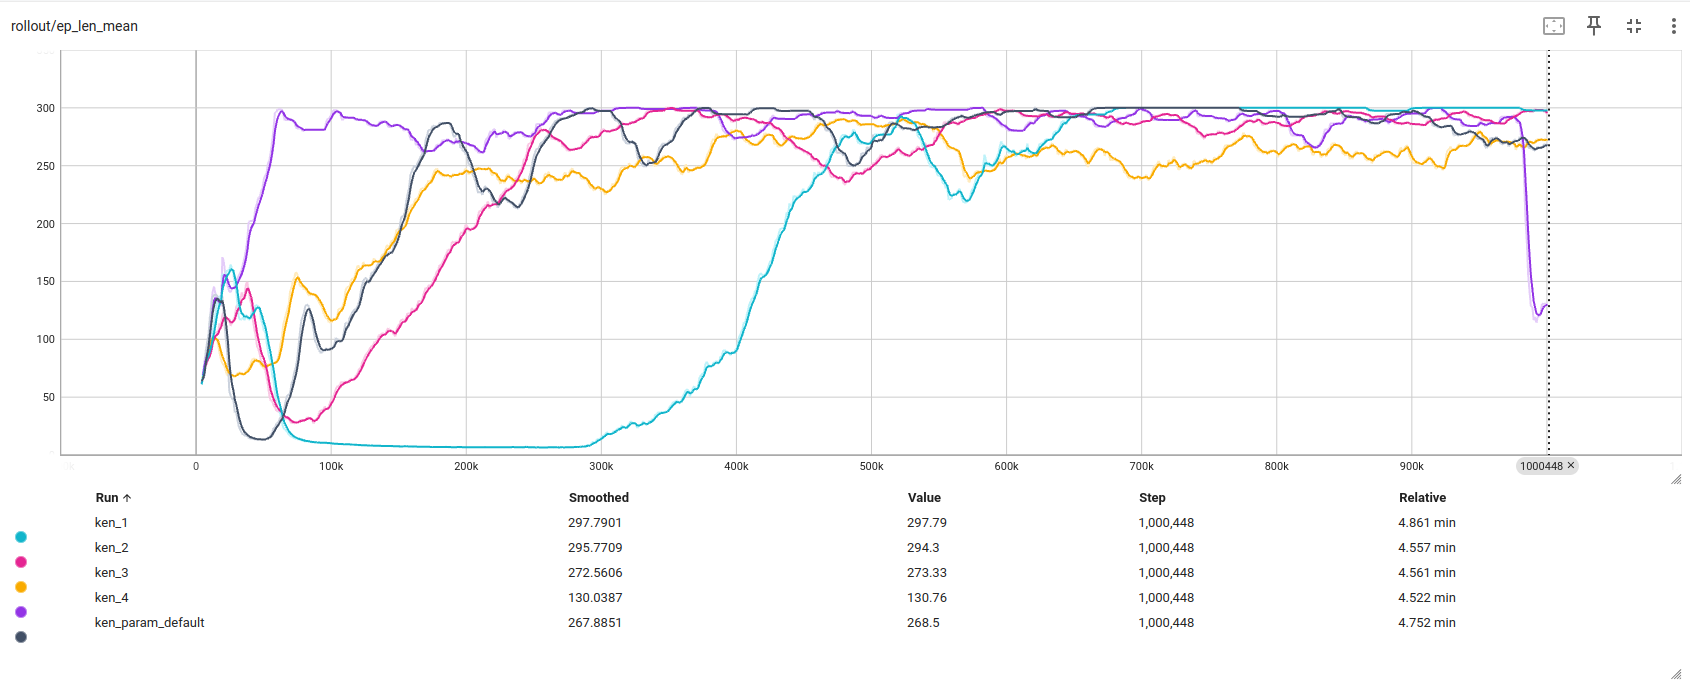

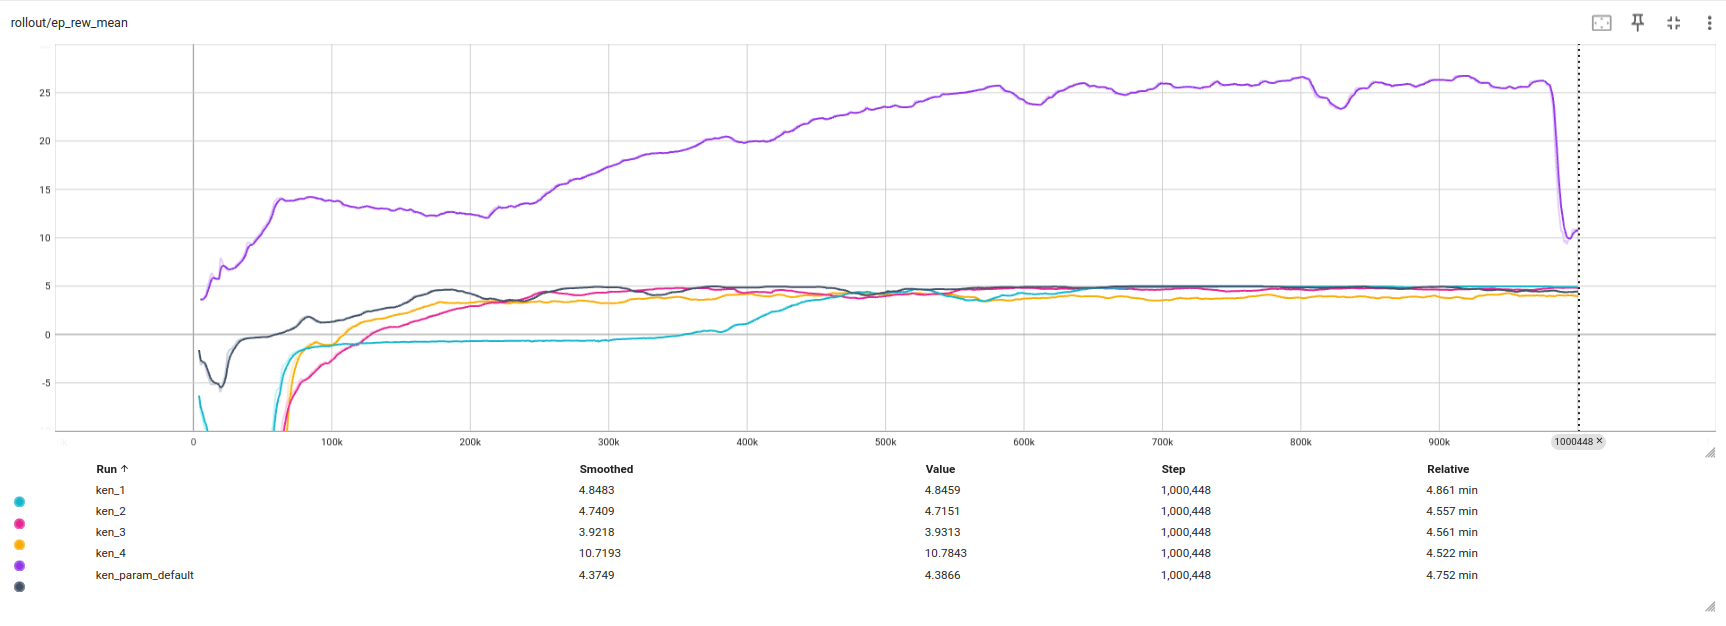

---


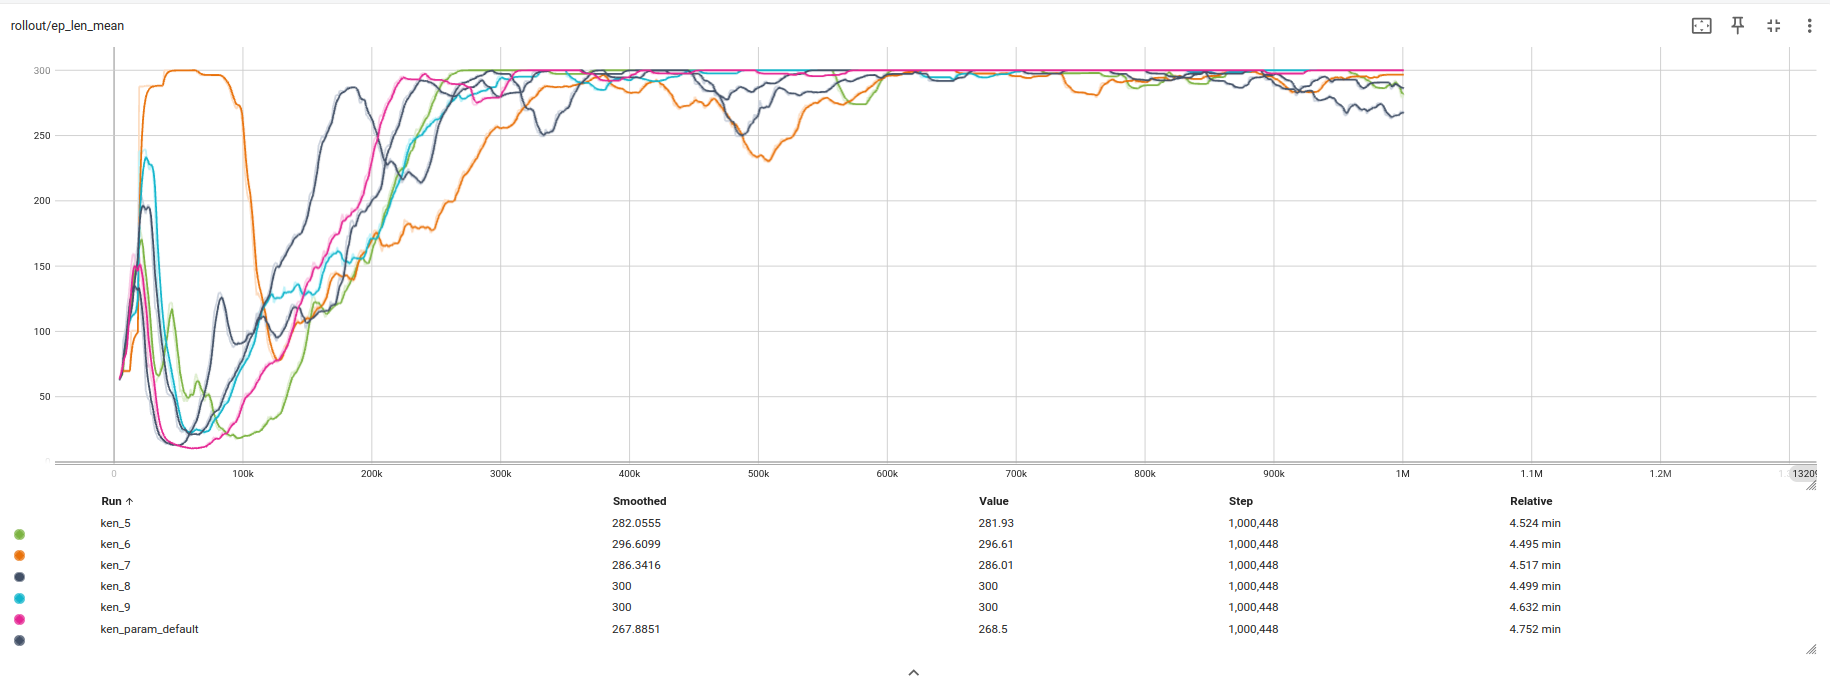

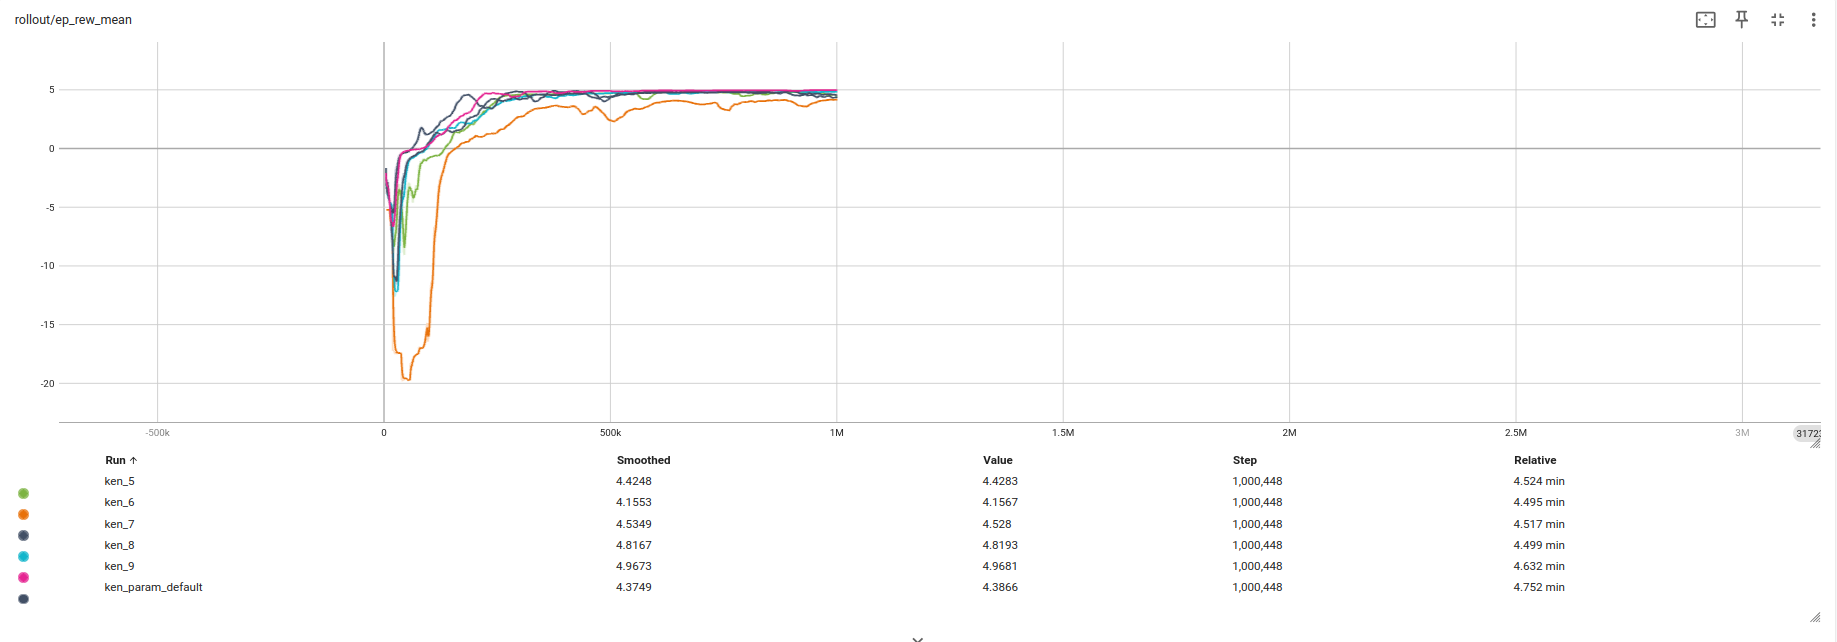

**Summary Result**
- in some configuration agent can get a lot of reward or converge to maximum reward faster tha other configure but sometime reward not represent that primary or sub task in success it's depend on reward function and weight